In [1]:
# import required libraries

import pandas as pd
import numpy as np
from scipy.stats import gmean
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# parse the data
# data is an xlsx containing general info about samples (lcp, lcp replica, Ig type, concentration, gene)
# and qPCR Cq results (Cq aka Ct, Mean Cq for 2 reps, Cq stdev)
lcp = pd.read_excel('C:/Users/mgika/Documents/ИБХ/FCRL4_5/lcp_samples/lcp_fcrl_hk_Ct.xlsx')

# drop non-normalized samples
lcp = lcp.loc[lcp.Conc>=2].loc[lcp.Conc<2.1].reset_index(drop=True)

# drop samles with failed qPCR
lcp = lcp[lcp['Cq Mean'] != 0]

lcp.head()

,Sample,Biological Set Name,Ig_type,Target,Cq,Cq Mean,Cq Std. Dev,Conc
0,lcp7-1,lcp 7,IgA,FCRL4,25.896157,25.597753,0.422008,2.0
1,lcp7-1,lcp 7,IgA,FCRL4,25.299348,25.597753,0.422008,2.0
2,lcp7-1,lcp 7,IgA,FCRL5,23.273707,23.412243,0.195919,2.0
3,lcp7-1,lcp 7,IgA,FCRL5,23.550779,23.412243,0.195919,2.0
4,lcp7-1,lcp 7,IgA,ABL1,27.555618,27.293769,0.370311,2.0


In [ ]:
# Pfaffl equation with multiple reference genes
# source: https://toptipbio.com/qpcr-multiple-reference-genes/

In [4]:
# calculate the avg Ct for every gene

calibr_ct = lcp.groupby('Target').agg({'Cq Mean':'mean'}).reset_index()
calibr_ct

,Target,Cq Mean
0,ABL1,25.479731
1,FCRL4,26.175158
2,FCRL5,22.422887
3,GUSB,20.361071
4,HPRT,19.230482
5,TBP,21.465274


In [5]:
# define a function to insert the avg Cts into the df

def set_value_calibr(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary
gene_dictionary ={'ABL1' : calibr_ct['Cq Mean'][0], 'FCRL4' : calibr_ct['Cq Mean'][1], 'FCRL5' : calibr_ct['Cq Mean'][2], 
                  'GUSB' : calibr_ct['Cq Mean'][3],'HPRT' : calibr_ct['Cq Mean'][4], 'TBP' : calibr_ct['Cq Mean'][5]}
 
# Add a new column named 'calibr_ct'
lcp['calibr_cq'] = lcp['Target'].apply(set_value_calibr, args =(gene_dictionary, ))


In [6]:
# calculate the difference between the avg Ct and the samples' Ct

lcp['delta_cq'] = lcp['calibr_cq'] - lcp['Cq Mean']

In [7]:
# define a function to insert the converted primer efficiency (E) into the df

def set_value_E(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary
# E was calculated elsewhere with the formula : [E = E_not_converted(%) / 100 + 1]
gene_dictionary_E ={'ABL1' : 1.876, 'FCRL4' : 1.869, 'FCRL5' : 1.963, 
                  'GUSB' : 2.053,'HPRT' : 1.955, 'TBP' : 1.98}
 
# Add a new column named 'calibr_ct'
lcp['E'] = lcp['Target'].apply(set_value_E, args =(gene_dictionary_E, ))

In [8]:
# calculate relative quantity (RQ)

lcp['RQ'] = lcp.E ** lcp.delta_cq

In [9]:
# define gene types : reference and gene of interest(goi)

hk_gns = ['ABL1', 'GUSB', 'HPRT', 'TBP']
lcp['gene_type'] = ['ref' if x in hk_gns else 'goi' for x in lcp['Target']]

In [10]:
# calculate geometric mean for housekeeping genes (ref genes)

gm = lcp[lcp.gene_type == 'ref'].groupby(['Sample']).RQ.apply(gmean)
gm = gm.to_dict()

In [15]:
# define a function to insert the geomean into the df

def set_value_gm(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary
gene_dictionary_gm =gm
 
# Add a new column named 'calibr_ct'
lcp['gm'] = lcp['Sample'].apply(set_value_gm, args =(gene_dictionary_gm, ))

In [17]:
# group data related to ref genes
de_samples = lcp[lcp.gene_type == 'goi'].groupby(['Sample', 'Biological Set Name', 'Ig_type', 'Target']).agg({'E' : 'mean', 
                                                                               'RQ' : 'mean', 'gm' : 'mean'}).reset_index()
# rename a column
de_samples = de_samples.rename(columns={'Biological Set Name' : 'lcp'})

# calculate relative gene expression (RGE) with the formula : [RGE = RQ / ref genes geomean]
de_samples['RGE'] = de_samples.RQ / de_samples.gm
de_samples

,Sample,lcp,Ig_type,Target,E,RQ,gm,RGE
0,lcp12-20,lcp 12,IgA,FCRL4,1.869,0.643533,0.778118,0.827037
1,lcp12-20,lcp 12,IgA,FCRL5,1.963,0.395493,0.778118,0.508269
2,lcp15-22,lcp 15,IgA,FCRL4,1.869,4.934544,0.770775,6.402058
3,lcp15-22,lcp 15,IgA,FCRL5,1.963,1.074595,0.770775,1.394175
4,lcp15-23,lcp 15,IgG,FCRL4,1.869,0.000122,1.137972,0.000107
5,lcp15-23,lcp 15,IgG,FCRL5,1.963,0.529011,1.137972,0.464872
6,lcp15-24,lcp 15,IgA,FCRL4,1.869,5.042050,1.094824,4.605354
7,lcp15-24,lcp 15,IgA,FCRL5,1.963,0.383403,1.094824,0.350196
8,lcp16-26,lcp 16,IgA,FCRL4,1.869,19.049591,1.340131,14.214723
9,lcp16-26,lcp 16,IgA,FCRL5,1.963,1.538038,1.340131,1.147677


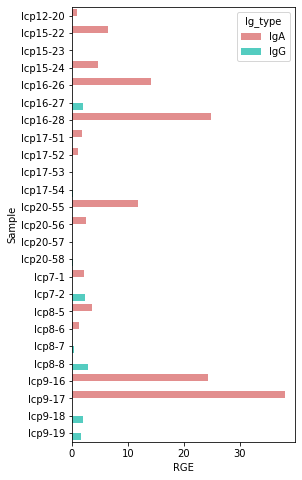

In [18]:
# plot the results for fcrl4

fig, ax = plt.subplots(figsize=(4, 8))
my_pal = {"IgA": "lightcoral", "IgG": "turquoise"}
sns.barplot(y='Sample', x='RGE', hue='Ig_type', data=de_samples[de_samples.Target=='FCRL4'], ci=None,
           palette=my_pal, ax=ax)
plt.show()

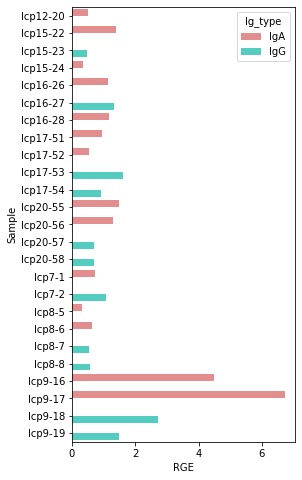

In [19]:
# plot the results for fcrl5

fig, ax = plt.subplots(figsize=(4, 8))
sns.barplot(y='Sample', x='RGE', hue='Ig_type', data=de_samples[de_samples.Target=='FCRL5'], ci=None,
           palette=my_pal, ax=ax)
plt.show()

In [20]:
# group biological replicas

de_lcp = de_samples.groupby(['lcp', 'Target', 'Ig_type']).agg({'RGE' : 'mean'}).reset_index()
de_lcp

,lcp,Target,Ig_type,RGE
0,lcp 12,FCRL4,IgA,0.827037
1,lcp 12,FCRL5,IgA,0.508269
2,lcp 15,FCRL4,IgA,5.503706
3,lcp 15,FCRL4,IgG,0.000107
4,lcp 15,FCRL5,IgA,0.872185
5,lcp 15,FCRL5,IgG,0.464872
6,lcp 16,FCRL4,IgA,19.573053
7,lcp 16,FCRL4,IgG,1.918006
8,lcp 16,FCRL5,IgA,1.164768
9,lcp 16,FCRL5,IgG,1.321625


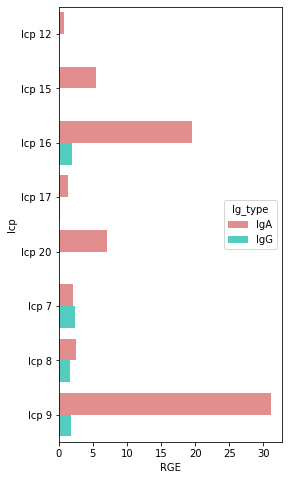

In [22]:
# plot the results for fcrl4

fig, ax = plt.subplots(figsize=(4, 8))
sns.barplot(y='lcp', x='RGE', hue='Ig_type', data=de_lcp[de_lcp.Target=='FCRL4'], ci=None,
           palette=my_pal, ax=ax)
plt.show()

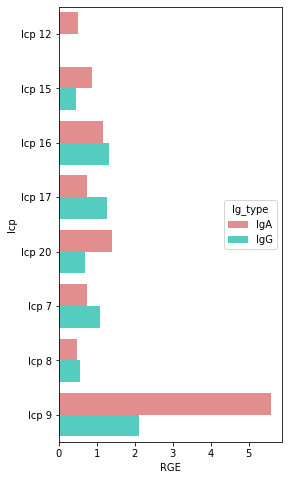

In [23]:
# plot the results for fcrl5

fig, ax = plt.subplots(figsize=(4, 8))
sns.barplot(y='lcp', x='RGE', hue='Ig_type', data=de_lcp[de_lcp.Target=='FCRL5'], ci=None,
           palette=my_pal, ax=ax)
plt.show()